In [44]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
from scipy import interpolate
from scipy import signal
from glob import glob
import scipy.ndimage
import matplotlib.colors as colors
from sklearn.linear_model import LinearRegression
import spectrum

#data directory for saildrone data
#more on the data here: https://podaac.jpl.nasa.gov/dataset/SAILDRONE_ATOMIC
# DOI = 10.5067/SDRON-ATOM0
data_dir = './data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#output
figs_dir = './figures/'

#subroutines for calculating PSD & making plot
def spectrum(data_in):
    #calculate PSD for each USV
    data_all=[]
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4.density_mean.interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
        freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/.080,nperseg=1024*30)  #fs = sampled at .08km or 80m
        if iusv==0:
            ps_all=Pxx_den[0:10000]
            ps_all_welch=Pxx_den2[0:10000]
        else:
            ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
            ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
    Pxx_den = np.mean(ps_all,axis=0)
    Pxx_den_welch = np.mean(ps_all_welch,axis=0)
    return freq,freq2,Pxx_den,Pxx_den_welch

def cal_pdf(data_in): 
    #make arrays for sampling at different length scales
    length_scale = np.arange(.1,200,1)
    # create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    data = np.zeros((len(length_scale),len(xx_in2)))
    ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
        ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
        for ilen2,len2 in enumerate(length_scale):
            dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
            ds4 = ds3.interp(dist_total=dist_interp)       
            den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
            result,xx = np.histogram(den_grad,bins=xx_in)
            ddn[ilen2,:]=ddn[ilen2,:]+result
    for ilen2,len2 in enumerate(length_scale):
        ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent

    return ddn


def psd_fig(f,data_in,Pxx_den,text1,fout,ifit):
   
    length_scale = np.arange(.1,200,1)
    xx_in = np.arange(0,.2,.001)
    xx_in2 = np.arange(0,.2-.001,.001)
    print(len(length_scale),len(xx_in))
    fig = plt.figure(figsize=(14,10))
    tem=data_in
    tem = tem.where(tem>.003)
    Z=tem.T
    ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
    plt.text(10,0.179,'(a)'+text1,fontsize=16,color='k')
    plt.xlabel('Length scale (km)',fontsize=16)
    plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
    cb = plt.colorbar()
    cb.set_label(label='Percent count',fontsize=16)

    plt.axes([.33, .47, .4, .4])

    #cal PSD
    #Pxx_den = np.mean(psd_in,axis=0)
    #f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
    istart,iend=10,5550
    plt.loglog(f[istart:iend], Pxx_den[istart:iend])

    #linear regression to PSD
    istart,iend=8,ifit
    XX = np.log(f[istart:iend])
    YY = np.log(Pxx_den[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(.02,10,slp_str,fontsize=16,color='r')
    plt.ylim([10e-6,10e1])
    plt.xlim([10e-4,10e-1])
    plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])

    plt.text(.0011,10,'(b)',fontsize=16,color='k')
    #plt.xlabel('Wavenumber (cpkm)')
    plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
    plt.grid()
    plt.savefig(figs_dir+fout)
    return

# Shane Elipot suggested slepian multitaper
def spec_time(data,var):
    import spectrum
    #calculate the periodogram spectrum spec_p
    #calculate the slepian multitaper spectrum spec_m
    ps_all,ps_all2=[],[]
    for iusv in range(3):
        ds_usv = data.isel(trajectory=iusv)
        den = ds_usv[var].interpolate_na(dim='time')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend_smooth = signal.detrend(den)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/1)  #fs = 1 min sampled at 80m
        ps_all.append(Pxx_den[0:10000])
        Sk_complex, weights, eigenvalues = spectrum.pmtm(ds4_detrend_smooth, NW=3.5, k=4, show=False)
        Sk = np.mean((abs(Sk_complex)**2) * weights.T, axis=0)
        ps_all2.append(Sk[0:10000])
    spec_p = np.mean(np.vstack(ps_all),axis=0)
    spec_m = np.mean(np.vstack(ps_all2),axis=0)
    return spec_p,spec_m,freq

def spec_dist(data,var):
    import spectrum
    #calculate the periodogram spectrum spec_p
    #calculate the slepian multitaper spectrum spec_m
    ps_all,ps_all2=[],[]
    for iusv in range(3):
        ds_usv = data.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],1) #0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4[var].interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        freq, Pxx_den = signal.periodogram(ds4_detrend,1) #/0.08)  #fs = 1 min sampled at 80m
        ps_all.append(Pxx_den[0:10000])
        Sk_complex, weights, eigenvalues = spectrum.pmtm(ds4_detrend, NW=3.5, k=4, show=False)
        Sk = np.mean((abs(Sk_complex)**2) * weights.T, axis=0)
        ps_all2.append(Sk[0:10000])
    spec_p = np.mean(np.vstack(ps_all),axis=0)
    spec_m = np.mean(np.vstack(ps_all2),axis=0)
    return spec_p,spec_m,freq




# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [15]:
ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()

#    #make diruanl plot
    xlon=ds_usv.longitude.ffill(dim='time').data
    time_offset_to_lmt=(xlon/360.)*24.*60
    tem = ds_usv.time+time_offset_to_lmt*np.timedelta64(1,'m') 
    ds_usv['tlmt']=tem

    ds_usv2= ds_usv.swap_dims({'time':'tlmt'})
    ds_usv2a = ds_usv2.where(ds_usv2.tlmt.dt.hour==6)
    dymn = ds_usv2a.groupby("tlmt.dayofyear").mean()
    ds_usv3 = ds_usv2.groupby("tlmt.dayofyear") - dymn
   
    ds_usv['TEMP_AIR_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_AIR_MEAN
    ds_usv['TEMP_SBE37_MEAN_DW'] = ds_usv3.swap_dims({'tlmt':'time'}).drop({'tlmt'}).TEMP_SBE37_MEAN
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)


In [75]:
data.dist_total.max(dim='time').min().data

array(5552.02967864)

Text(0, 0.5, 'PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')

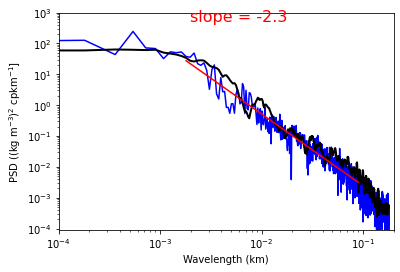

In [88]:
    import spectrum
    var = 'density_mean'
    #sp,sm,freq = spec_dist(ds_saildrone,var)
    data = ds_saildrone
    ps_all,ps_all2=[],[]
    mindist = data.dist_total.max(dim='time').min().data       
    for iusv in range(3):
        ds_usv = data.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        ds3 = ds3.sel(dist_total=slice(0,mindist))
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],1) #0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4[var].interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        freq, Pxx_den = signal.periodogram(ds4_detrend,1) #/0.08)  #fs = 1 min sampled at 80m
        ps_all.append(Pxx_den[0:10000])
        Sk_complex, weights, eigenvalues = spectrum.pmtm(ds4_detrend, NW=3.5, k=4, show=False)
        Sk = np.mean((abs(Sk_complex)**2) * weights.T, axis=0)
        ps_all2.append(Sk[0:10000])
    sp,sm = np.mean(np.vstack(ps_all),axis=0),np.mean(np.vstack(ps_all2),axis=0)
    
    dmin,dmax=np.floor(1000000*min(sp[1:1000]))/10000/9,np.ceil(max(sp[1:1000])/1000)*1000*2
    plt.loglog(freq[0:1000], sp[0:1000],'b')
    plt.loglog(freq[0:1000], sm[0:1000],'k',lw=2)
    plt.ylim([dmin/8,dmax/2])
    plt.xlim([10e-5,.2])
    ifit=500
    istart,iend=10,ifit
    XX = np.log(freq[istart:iend])
    YY = np.log(sp[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(freq[istart:iend], freq[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(freq[istart+1],freq[istart]**(a)/np.exp(b)+500,slp_str,fontsize=16,color='r')      
    plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')

In [ ]:

freq_usv,freq2_usv,Pxx_den_usv,Pxx_den_welch_usv = spectrum(ds)

ddn_usv = cal_pdf(ds)


In [ ]:
psd_fig(freq_usv,ddn_usv,Pxx_den_usv,'Saildrone','PSD_den_grad_usv.png',300)
psd_fig(freq_usv,ddn_usv,Pxx_den_usv,'Saildrone','PSD_den_grad_usv.pdf',300)
